# CSE 275 Homework 3

Author: Kevin Chan A17506771

Reference: Followed the step-by-step [NeRF From Nothing tutorial](https://towardsdatascience.com/its-nerf-from-nothing-build-a-vanilla-nerf-with-pytorch-7846e4c45666) and its respective collab to build my NeRF model.

## Import Bottles Dataset and split to train, val, test datasets

In [2]:
import os
from typing import Optional, Tuple, List, Union, Callable
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from PIL import Image
import glob

seed = 275
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_images(images_directory):
    images_list = []
    for image_path in images_directory:
        with Image.open(image_path) as img:
            image = np.array(img).astype(np.float32) / 255.0
            image = image[..., :3] * image[..., 3:] + (1.0 - image[..., 3:]) # To composite onto a white background, use alpha map.
            images_list.append(image)
    return torch.from_numpy(np.array(images_list)).float()
def load_poses(poses_directory):
    poses_list = []
    for pose_path in poses_directory:
        with open(pose_path, 'rb') as file:
            pose = np.loadtxt(file).astype(np.float32)
            pose[:, 1:3] = pose[:, 1:3] * -1 #convert to opengl convention
            poses_list.append(pose)
    return torch.from_numpy(np.array(poses_list)).float()

train_images_dir = glob.glob("./bottles/rgb/0_train_*.png")
train_images_dir.sort()
train_poses_dir = glob.glob("./bottles/pose/0_train_*.txt")
train_poses_dir.sort()

val_split_images_dir = glob.glob("./bottles/rgb/1_val_*.png")
val_split_images_dir.sort()
val_split_poses_dir = glob.glob("./bottles/pose/1_val_*.txt")
val_split_poses_dir.sort()

# merge 90 val into train. keep the 10 tenth (00, 10, 20, ...)

val_images_dir = val_split_images_dir[10::20]
val_poses_dir = val_split_poses_dir[10::20]

val_split_images_dir = [e for i, e in enumerate(val_split_images_dir) if (i+10) % 20 != 0]
val_split_poses_dir = [e for i, e in enumerate(val_split_poses_dir) if (i+10) % 20 != 0]

train_images_dir.extend(val_split_images_dir)
train_poses_dir.extend(val_split_poses_dir)

test_tags = ['0000', '0016', '0055', '0093', '0160']
test_poses_dir = []
for tag in test_tags:
    test_poses_dir.append(f"./bottles/pose/2_test_{tag}.txt")

with open("./bottles/intrinsics.txt", 'r') as f:
    intrinsics = np.loadtxt(f)
focal = intrinsics[0][0]

train_images = load_images(train_images_dir)
train_poses = load_poses(train_poses_dir)
val_images = load_images(val_images_dir)
val_poses = load_poses(val_poses_dir)
test_poses = load_poses(test_poses_dir)

In [3]:
train_images.shape

torch.Size([195, 800, 800, 3])

## NeRF Model Methods

In [4]:
# Referenced and modified greatly from NeRF From Nothing tutorial

def sample_stratified(
    rays_o: torch.Tensor,
    rays_d: torch.Tensor,
    near: float,
    far: float,
    n_samples: int,
    perturb: Optional[bool] = True
) -> Tuple[torch.Tensor, torch.Tensor]:
    
    t_vals = torch.linspace(0., 1., n_samples, device=rays_o.device)
    z_vals = near * (1.-t_vals) + far * (t_vals)

    if perturb:
        mids = .5 * (z_vals[1:] + z_vals[:-1])
        upper = torch.concat([mids, z_vals[-1:]], dim=-1)
        lower = torch.concat([z_vals[:1], mids], dim=-1)
        t_rand = torch.rand([n_samples], device=z_vals.device)
        z_vals = lower + (upper - lower) * t_rand
        z_vals = z_vals.expand(list(rays_o.shape[:-1]) + [n_samples])

    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]
    return pts, z_vals
    
class PositionalEncoder(nn.Module):
    def __init__(
        self, 
        d_input: int,
        n_freqs: int,
        log_space: bool = False
    ):
        super().__init__()
        self.d_input = d_input
        self.n_freqs = n_freqs
        self.log_space = log_space
        self.d_output = d_input * (1 + 2 * self.n_freqs)
        self.embed_fns = [lambda x: x]

        if self.log_space:
            freq_bands = 2.**torch.linspace(0., self.n_freqs - 1, self.n_freqs) # using log space
        else:
            freq_bands = torch.linspace(2.**0., 2.**(self.n_freqs - 1), self.n_freqs)

        for freq in freq_bands:
            self.embed_fns.append(lambda x, freq=freq: torch.sin(x * freq))
            self.embed_fns.append(lambda x, freq=freq: torch.cos(x * freq))

    def forward(self, x) -> torch.Tensor:
        return torch.concat([fn(x) for fn in self.embed_fns], dim=-1)

class NeRF(nn.Module):
    def __init__(
        self,
        d_input: int = 3,
        n_layers: int = 8,
        d_filter: int = 256,
        skip: Tuple[int] = (4,),
        d_viewdirs: Optional[int] = None
    ):
        super().__init__()
        self.d_input = d_input
        self.skip = skip
        self.act = nn.functional.relu
        self.d_viewdirs = d_viewdirs
        self.layers = nn.ModuleList(
            [nn.Linear(self.d_input, d_filter)] +
            [nn.Linear(d_filter + self.d_input, d_filter) if i in skip \
             else nn.Linear(d_filter, d_filter) for i in range(n_layers - 1)])
        self.alpha_out = nn.Linear(d_filter, 1)
        self.rgb_filters = nn.Linear(d_filter, d_filter)
        self.branch = nn.Linear(d_filter + self.d_viewdirs, d_filter // 2)
        self.output = nn.Linear(d_filter // 2, 3)

    def forward(self, x: torch.Tensor, viewdirs: Optional[torch.Tensor] = None) -> torch.Tensor:
        x_input = x
        for i, layer in enumerate(self.layers):
            x = self.act(layer(x))
            if i in self.skip:
                x = torch.cat([x, x_input], dim=-1)
        alpha = self.alpha_out(x)
        x = self.rgb_filters(x)
        x = torch.concat([x, viewdirs], dim=-1)
        x = self.act(self.branch(x))
        x = self.output(x)
        x = torch.concat([x, alpha], dim=-1)
        return x

def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
    cumprod = torch.cumprod(tensor, -1)
    cumprod = torch.roll(cumprod, 1, -1)
    cumprod[..., 0] = 1.
    return cumprod

def raw2outputs(
    raw: torch.Tensor,
    z_vals: torch.Tensor,
    rays_d: torch.Tensor,
    raw_noise_std: float = 0.0,
    white_bkgd: bool = True # set to true for bottles dataset
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:

    # Difference between consecutive elements of z_vals. [n_rays, n_samples]
    dists = z_vals[..., 1:] - z_vals[..., :-1]
    dists = torch.cat([dists, 1e10 * torch.ones_like(dists[..., :1])], dim=-1)

    # Multiply each distance by the norm of its corresponding direction ray to convert to real world distance (accounts for non-unit directions).
    dists = dists * torch.norm(rays_d[..., None, :], dim=-1)

    # Add noise to model's predictions for density. Can be used to regularize network during training (prevents floater artifacts).
    noise = 0.
    if raw_noise_std > 0.:
        noise = torch.randn(raw[..., 3].shape) * raw_noise_std

    # Predict density of each sample along each ray. Higher values imply higher likelihood of being absorbed at this point. [n_rays, n_samples]
    alpha = 1.0 - torch.exp(-nn.functional.relu(raw[..., 3] + noise) * dists)

    # Compute weight for RGB of each sample along each ray. The higher the alpha, the lower subsequent weights are driven. [n_rays, n_samples] 
    weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

    # Compute weighted RGB map.
    rgb = torch.sigmoid(raw[..., :3])  # [n_rays, n_samples, 3]
    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)  # [n_rays, 3]

    # Estimated depth map is predicted distance.
    depth_map = torch.sum(weights * z_vals, dim=-1)

    # Sum of weights along each ray.
    acc_map = torch.sum(weights, dim=-1)

    # To composite onto a white background, use the accumulated alpha map.
    if white_bkgd:
        rgb_map = rgb_map + (1. - acc_map[..., None])

    return rgb_map, depth_map, acc_map, weights

def sample_pdf(bins: torch.Tensor, weights: torch.Tensor, n_samples: int, perturb: bool = False) -> torch.Tensor:

    # Normalize weights to get PDF.
    pdf = (weights + 1e-5) / torch.sum(weights + 1e-5, -1, keepdims=True) # [n_rays, weights.shape[-1]]

    # Convert PDF to CDF.
    cdf = torch.cumsum(pdf, dim=-1) # [n_rays, weights.shape[-1]]
    cdf = torch.concat([torch.zeros_like(cdf[..., :1]), cdf], dim=-1) # [n_rays, weights.shape[-1] + 1]

    # Take sample positions to grab from CDF. Linear when perturb == 0.
    if not perturb:
        u = torch.linspace(0., 1., n_samples, device=cdf.device)
        u = u.expand(list(cdf.shape[:-1]) + [n_samples]) # [n_rays, n_samples]
    else:
        u = torch.rand(list(cdf.shape[:-1]) + [n_samples], device=cdf.device) # [n_rays, n_samples]

    # Find indices along CDF where values in u would be placed.
    u = u.contiguous() # Returns contiguous tensor with same values.
    inds = torch.searchsorted(cdf, u, right=True) # [n_rays, n_samples]

    # Clamp indices that are out of bounds.
    below = torch.clamp(inds - 1, min=0)
    above = torch.clamp(inds, max=cdf.shape[-1] - 1)
    inds_g = torch.stack([below, above], dim=-1) # [n_rays, n_samples, 2]

    # Sample from cdf and the corresponding bin centers.
    matched_shape = list(inds_g.shape[:-1]) + [cdf.shape[-1]]
    cdf_g = torch.gather(cdf.unsqueeze(-2).expand(matched_shape), dim=-1,index=inds_g)
    bins_g = torch.gather(bins.unsqueeze(-2).expand(matched_shape), dim=-1,index=inds_g)

    # Convert samples to ray length.
    denom = (cdf_g[..., 1] - cdf_g[..., 0])
    denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
    t = (u - cdf_g[..., 0]) / denom
    samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

    return samples # [n_rays, n_samples]

def sample_hierarchical(
    rays_o: torch.Tensor,
    rays_d: torch.Tensor,
    z_vals: torch.Tensor,
    weights: torch.Tensor,
    n_samples: int,
    perturb: bool = False
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

    # Draw samples from PDF using z_vals as bins and weights as probabilities.
    z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
    new_z_samples = sample_pdf(z_vals_mid, weights[..., 1:-1], n_samples, perturb=perturb)
    new_z_samples = new_z_samples.detach()

    # Resample points from ray based on PDF.
    z_vals_combined, _ = torch.sort(torch.cat([z_vals, new_z_samples], dim=-1), dim=-1)
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals_combined[..., :, None]  # [N_rays, N_samples + n_samples, 3]
    return pts, z_vals_combined, new_z_samples

In [5]:
def get_rays(height: int, width: int, focal_length: float, c2w: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    # Apply pinhole camera model to gather directions at each pixel
    i, j = torch.meshgrid(
        torch.arange(width, dtype=torch.float32).to(c2w),
        torch.arange(height, dtype=torch.float32).to(c2w),
        indexing='ij')
    i, j = i.transpose(-1, -2), j.transpose(-1, -2)
    directions = torch.stack([(i - width * .5) / focal_length, -(j - height * .5) / focal_length, -torch.ones_like(i)], dim=-1)
    rays_d = torch.sum(directions[..., None, :] * c2w[:3, :3], dim=-1)
    rays_o = c2w[:3, -1].expand(rays_d.shape)
    return rays_o, rays_d

def get_chunks(inputs: torch.Tensor, chunksize: int = 2**15) -> List[torch.Tensor]:
    return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

def prepare_chunks(points: torch.Tensor, encoding_function: Callable[[torch.Tensor], torch.Tensor], chunksize: int = 2**15) -> List[torch.Tensor]:
    points = points.reshape((-1, 3))
    points = encoding_function(points)
    points = get_chunks(points, chunksize=chunksize)
    return points

def prepare_viewdirs_chunks(points: torch.Tensor, rays_d: torch.Tensor, encoding_function: Callable[[torch.Tensor], torch.Tensor], chunksize: int = 2**15) -> List[torch.Tensor]:
    viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
    viewdirs = viewdirs[:, None, ...].expand(points.shape).reshape((-1, 3))
    viewdirs = encoding_function(viewdirs)
    viewdirs = get_chunks(viewdirs, chunksize=chunksize)
    return viewdirs
    
def nerf_forward(
    rays_o: torch.Tensor,
    rays_d: torch.Tensor,
    near: float,
    far: float,
    encoding_fn: Callable[[torch.Tensor], torch.Tensor],
    coarse_model: nn.Module,
    kwargs_sample_stratified: dict = {},
    n_samples_hierarchical: int = 0,
    kwargs_sample_hierarchical: dict = {},
    fine_model = nn.Module,
    viewdirs_encoding_fn: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
    chunksize: int = 2**15,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, dict]:
    # Apply stratified sampling for coarse query points
    query_points, z_vals = sample_stratified(rays_o, rays_d, near, far, **kwargs_sample_stratified)

    batches = prepare_chunks(query_points, encoding_fn, chunksize=chunksize)
    batches_viewdirs = prepare_viewdirs_chunks(query_points, rays_d, viewdirs_encoding_fn, chunksize=chunksize)

    # Coarse model pass
    predictions = []
    for batch, batch_viewdirs in zip(batches, batches_viewdirs):
        predictions.append(coarse_model(batch, viewdirs=batch_viewdirs))
    raw = torch.cat(predictions, dim=0)
    raw = raw.reshape(list(query_points.shape[:2]) + [raw.shape[-1]])
    # Differentiable volume rendering
    rgb_map_0, depth_map_0, acc_map_0, weights = raw2outputs(raw, z_vals, rays_d)
    
    # Coarse values to output
    outputs = {'z_vals_stratified': z_vals}
    outputs['rgb_map_0'] = rgb_map_0
    outputs['depth_map_0'] = depth_map_0
    outputs['acc_map_0'] = acc_map_0
    
    # Apply hierarchical sampling for fine query points
    query_points, z_vals_combined, z_hierarch = sample_hierarchical(
        rays_o, rays_d, z_vals, weights, n_samples_hierarchical,
        **kwargs_sample_hierarchical)

    batches = prepare_chunks(query_points, encoding_fn, chunksize=chunksize)
    batches_viewdirs = prepare_viewdirs_chunks(query_points, rays_d, viewdirs_encoding_fn, chunksize=chunksize)

    # Forward pass through fine model
    predictions = []
    for batch, batch_viewdirs in zip(batches, batches_viewdirs):
        predictions.append(fine_model(batch, viewdirs=batch_viewdirs))
    raw = torch.cat(predictions, dim=0)
    raw = raw.reshape(list(query_points.shape[:2]) + [raw.shape[-1]])

    rgb_map, depth_map, acc_map, weights = raw2outputs(raw, z_vals_combined, rays_d)

    # Fine values to output
    outputs['z_vals_hierarchical'] = z_hierarch
    outputs['rgb_map'] = rgb_map
    outputs['depth_map'] = depth_map
    outputs['acc_map'] = acc_map
    outputs['weights'] = weights
    return outputs

## Hyperparameters

In [6]:
# Problem-specific
near, far = 0., 5.
height, width = 800, 800

# Encoders
d_input = 3 # Number of input dimensions
n_freqs = 10 # Number of encoding functions for samples
log_space = True # If set, frequencies scale in log space
n_freqs_views = 4 # Number of encoding functions for views

# Samples
n_samples = 64 # Number of stratified samples per ray
n_samples_hierarchical = 64 # Number of hierarchical samples per ray
perturb = True # If set, applies noise to sample positions
kwargs_sample_stratified = {'n_samples': n_samples, 'perturb': perturb}
kwargs_sample_hierarchical = {'perturb': perturb}

# Model
d_filter = 384 # Dimensions of linear layer filters
n_layers = 12 # Number of layers in network bottleneck
skip = [6] # Layers at which to apply input residual

# Training
lr = 5e-4
n_iters = 200000
chunksize = 2**14 # Modify as needed to fit in GPU memory
display_rate = 2500 # Log val output

## Training

In [7]:
def init_models():
    encoder = PositionalEncoder(d_input, n_freqs, log_space=log_space)
    encoder_viewdirs = PositionalEncoder(d_input, n_freqs_views,log_space=log_space)
    d_viewdirs = encoder_viewdirs.d_output

    model = NeRF(encoder.d_output, n_layers=n_layers, d_filter=d_filter, skip=skip, d_viewdirs=d_viewdirs).to(device)
    fine_model = NeRF(encoder.d_output, n_layers=n_layers, d_filter=d_filter, skip=skip, d_viewdirs=d_viewdirs).to(device)

    optimizer = torch.optim.Adam(list(model.parameters()) + list(fine_model.parameters()), lr=lr)

    return model, fine_model, encoder, encoder_viewdirs, optimizer

In [8]:
def train():
    train_psnrs = []
    val_psnrs = []
    iternums = []
    for i in trange(n_iters):
        model.train()
        target_img_idx = np.random.randint(train_images.shape[0])
        target_img = train_images[target_img_idx]#.to(device)
        target_pose = train_poses[target_img_idx]#.to(device)
        rays_o, rays_d = get_rays(height, width, focal, target_pose)
        rays_o = rays_o.reshape([-1, 3])
        rays_d = rays_d.reshape([-1, 3])
    
        # sample some rays from image but not all
        indices = np.random.choice(rays_o.shape[0], 2500, replace=False)
        rays_o = rays_o[indices].to(device)
        rays_d = rays_d[indices].to(device)
    
        target_img = target_img.reshape([-1, 3])
        target_img = target_img[indices].to(device)
    
        outputs = nerf_forward(rays_o, rays_d,
                               near, far, encode, model,
                               kwargs_sample_stratified=kwargs_sample_stratified,
                               n_samples_hierarchical=n_samples_hierarchical,
                               kwargs_sample_hierarchical=kwargs_sample_hierarchical,
                               fine_model=fine_model,
                               viewdirs_encoding_fn=encode_viewdirs,
                               chunksize=chunksize)

        # Backprop
        rgb_predicted = outputs['rgb_map']
        rgb_predicted = torch.clamp(rgb_predicted, 0, 1)
        loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
        combined_loss = loss + torch.nn.functional.mse_loss(outputs['rgb_map_0'], target_img) # including the coarse loss
        combined_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        psnr = -10. * torch.log10(loss)
        train_psnrs.append(psnr.item())

        if i % display_rate == 0 or i == 250:
            model.eval()
            val_idx = np.random.randint(val_images.shape[0])
            val_img = val_images[val_idx].to(device)
            val_pose = val_poses[val_idx].to(device)
            rays_o, rays_d = get_rays(height, width, focal, val_pose)
      
            # row by row
            combined_outputs = {'rgb_map':[],'rgb_map_0':[], 'depth_map':[]}
            for row_idx in range(0, height):
                with torch.no_grad():
                    outputs = nerf_forward(rays_o[row_idx], rays_d[row_idx],
                                           near, far, encode, model,
                                           kwargs_sample_stratified=kwargs_sample_stratified,
                                           n_samples_hierarchical=n_samples_hierarchical,
                                           kwargs_sample_hierarchical=kwargs_sample_hierarchical,
                                           fine_model=fine_model,
                                           viewdirs_encoding_fn=encode_viewdirs,
                                           chunksize=chunksize)
                    combined_outputs['rgb_map'].extend(outputs['rgb_map'])
                    combined_outputs['rgb_map_0'].extend(outputs['rgb_map_0'])
                    combined_outputs['depth_map'].extend(outputs['depth_map'])
      
            rgb_predicted = torch.stack(combined_outputs['rgb_map'])
            rgb_predicted = torch.clamp(rgb_predicted, 0, 1)
      
            loss = torch.nn.functional.mse_loss(rgb_predicted, val_img.reshape(-1, 3))
            combined_loss = loss + torch.nn.functional.mse_loss(torch.stack(combined_outputs['rgb_map_0']), val_img.reshape(-1, 3)) # including the coarse loss
            print("Loss:", combined_loss.item())
            val_psnr = -10. * torch.log10(loss)
            val_psnrs.append(val_psnr.item())
            iternums.append(i)
    

            fig, ax = plt.subplots(1, 4, figsize=(24,4), gridspec_kw={'width_ratios': [1, 1, 1, 1]})
            # Figure 0: Depth map
            depth_map = torch.stack(combined_outputs['depth_map'])
            ax[0].imshow(depth_map.reshape([height, width]).detach().cpu().numpy())
            ax[0].set_title(f'Iteration: {i}')
            # Figure 1: Prediction RGB
            ax[1].imshow(rgb_predicted.reshape([height, width, 3]).detach().cpu().numpy())
            ax[1].set_title(f'Prediction')
            # Figure 2: Ground Truth RGB
            ax[2].imshow(val_img.detach().cpu().numpy())
            ax[2].set_title(f'Ground Truth')
            # Figure 3: PSNR Graph
            ax[3].plot(range(0, i + 1), train_psnrs, 'r')
            ax[3].plot(iternums, val_psnrs, 'b')
            ax[3].set_title('PSNR (train=red, val=blue)')
            plt.savefig(f"log/iter_{i}.png")
            plt.show()
    
        if i % (display_rate*2) == 0 and i > 0:
            torch.save(model.state_dict(), 'nerf.pt')
            torch.save(fine_model.state_dict(), 'nerf-fine.pt')

    return train_psnrs, val_psnrs

  0%|          | 0/200000 [00:00<?, ?it/s]

Loss: 0.3902289867401123


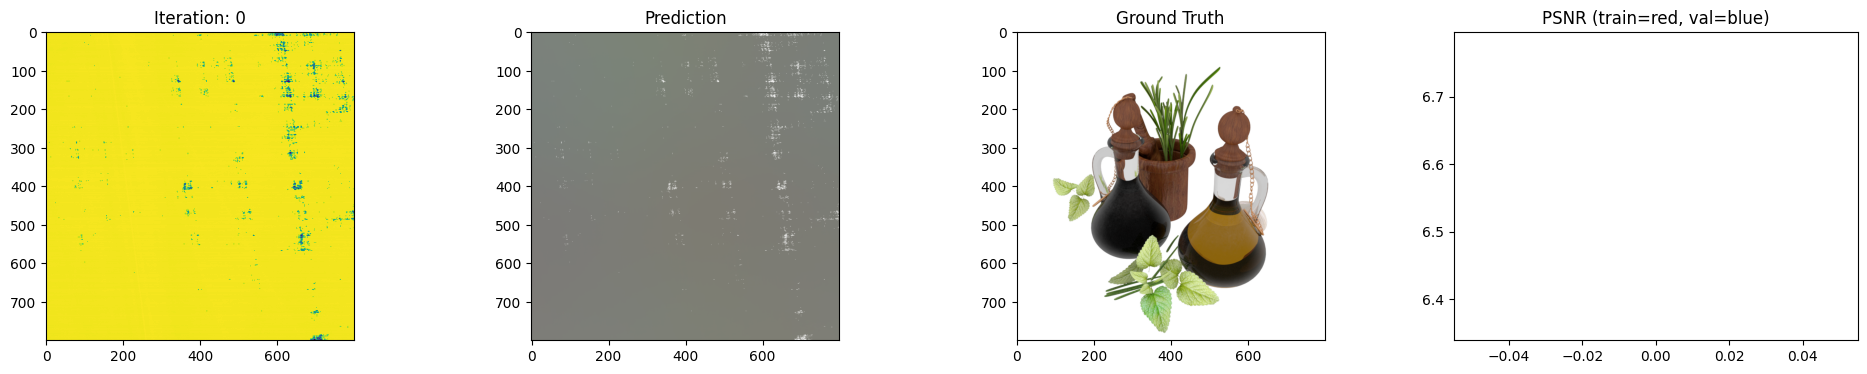

  0%|          | 250/200000 [00:38<6:11:26,  8.96it/s]

Loss: 0.029876168817281723


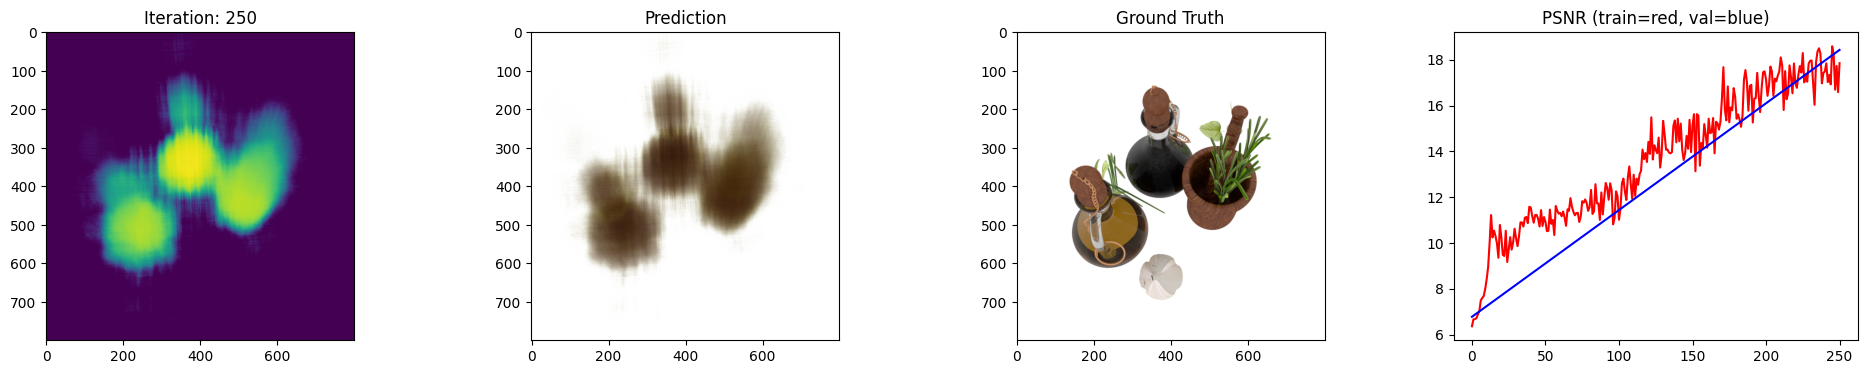

  1%|▏         | 2500/200000 [04:58<6:04:21,  9.03it/s] 

Loss: 0.013964853249490261


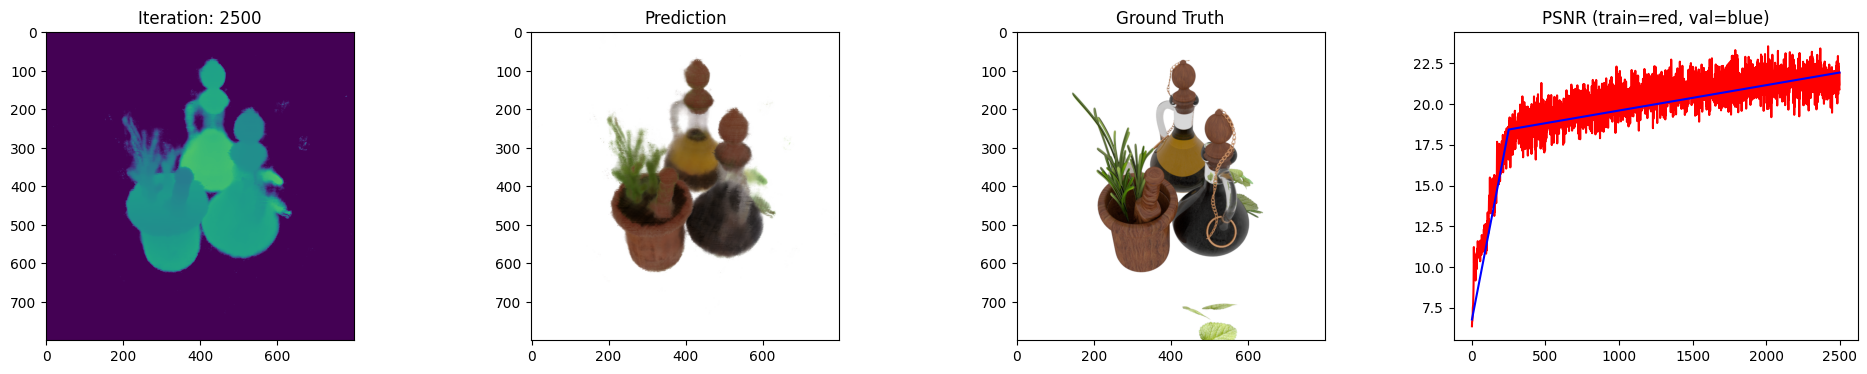

  2%|▏         | 3153/200000 [06:21<6:04:25,  9.00it/s]  

In [ ]:
model, fine_model, encode, encode_viewdirs, optimizer = init_models()
#model.load_state_dict(torch.load('nerf.pt'))
#fine_model.load_state_dict(torch.load('nerf-fine.pt'))

train_psnrs, val_psnrs = train()

torch.save(model.state_dict(), 'nerf.pt')
torch.save(fine_model.state_dict(), 'nerf-fine.pt')

In [27]:
torch.save(model.state_dict(), 'nerf.pt')
torch.save(fine_model.state_dict(), 'nerf-fine.pt')

## Predict Test Images

In [8]:
model, fine_model, encode, encode_viewdirs, optimizer = init_models()
model.load_state_dict(torch.load('nerf.pt'))
fine_model.load_state_dict(torch.load('nerf-fine.pt'))

<All keys matched successfully>

In [9]:
for i, test_idx in enumerate(tqdm(test_tags)):
    test_pose = test_poses[i].to(device)
    rays_o, rays_d = get_rays(width, height, focal, test_pose)
    
    # row by row
    combined_outputs = {'rgb_map':[],'rgb_map_0':[], 'depth_map':[]}
    for row_idx in range(0, height):
        with torch.no_grad():
            outputs = nerf_forward(rays_o[row_idx], rays_d[row_idx],
                                   near, far, encode, model,
                                   kwargs_sample_stratified=kwargs_sample_stratified,
                                   n_samples_hierarchical=n_samples_hierarchical,
                                   kwargs_sample_hierarchical=kwargs_sample_hierarchical,
                                   fine_model=fine_model,
                                   viewdirs_encoding_fn=encode_viewdirs,
                                   chunksize=chunksize)
            combined_outputs['rgb_map'].extend(outputs['rgb_map'])
            combined_outputs['rgb_map_0'].extend(outputs['rgb_map_0'])
            combined_outputs['depth_map'].extend(outputs['depth_map'])
    
    rgb_predicted = torch.stack(combined_outputs['rgb_map'])
    rgb_predicted = torch.clamp(rgb_predicted, 0, 1)

    plt.imsave(f"prediction/2_test_{test_idx}.png", rgb_predicted.reshape([height, width, 3]).detach().cpu().numpy())

    depth_map = torch.stack(combined_outputs['depth_map'])
    plt.imsave(f"prediction/2_test_{test_idx}_dm.png", depth_map.reshape([height, width]).detach().cpu().numpy())

100%|██████████| 5/5 [00:51<00:00, 10.31s/it]
